In [1]:
from train.src.model import get_model

In [2]:
from train.src.preprocessing import create_data_loaders

In [3]:
_, _, test_loader = create_data_loaders('official_data')

In [4]:
test_loader

In [5]:
len(test_loader.dataset)

123

In [6]:
test_loader.dataset.classes

['circle',
 'incomplete_fusion',
 'incomplete_penetration',
 'line',
 'pit',
 'undercut']

In [7]:
model = get_model(len(test_loader.dataset.classes))

/home/lesliebinbin/codings/dh-computer-vision/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lesliebinbin/codings/dh-computer-vision/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
import torch

In [9]:
model.load_state_dict(torch.load('train/checkpoints-resnet34/best_model.pth')['model_state_dict'])

<All keys matched successfully>

In [10]:
model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
import numpy as np
y_true = []
y_pred = []
for inputs, labels in test_loader:
    y_true.append(labels)
    y_pred.append(model(inputs).detach().numpy())
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
y_pred = y_pred.argmax(axis=1)

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay

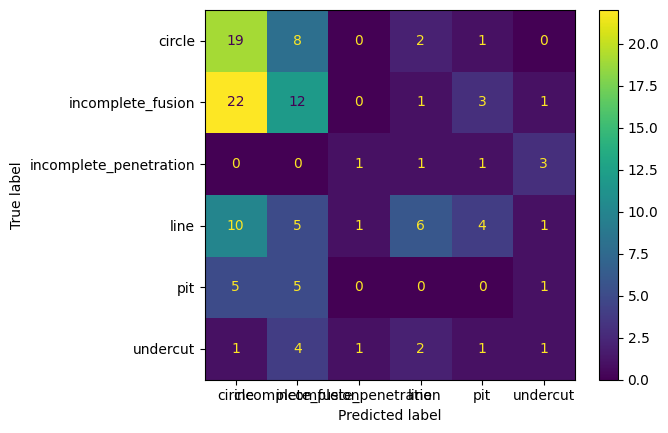

In [13]:
cm_display = ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels = test_loader.dataset.classes,
)

In [14]:
y_true == y_pred

array([ True, False,  True,  True, False,  True, False, False,  True,
        True,  True,  True, False,  True, False,  True,  True, False,
       False, False,  True,  True,  True,  True,  True, False,  True,
        True,  True, False,  True, False, False, False, False, False,
        True, False, False, False, False,  True,  True, False, False,
        True,  True,  True, False, False, False, False,  True,  True,
       False,  True, False, False, False, False, False,  True, False,
       False, False, False, False,  True, False,  True, False, False,
       False, False, False, False, False, False,  True,  True,  True,
       False, False, False, False, False, False, False, False,  True,
        True, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False])

In [15]:
from torchvision import transforms
val_transform = test_transform = transforms.Compose(
    [
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
        transforms.ToPILImage(),
    ]
)

In [17]:
import shutil
img_index = 0
from pathlib import Path
tgt_folder = Path("target_result")
tgt_folder.mkdir(parents=True, exist_ok=True)
from PIL import Image
from pydicom import dcmread
for index,(true_instance, pred_instance) in enumerate(zip(y_true, y_pred)):
    if true_instance != pred_instance:
        dcm_path = test_loader.dataset.samples[index][0]
        true_result = test_loader.dataset.classes[true_instance]
        pred_result = test_loader.dataset.classes[pred_instance]
        tgt_path = tgt_folder / f"{true_result}___{pred_result}_{img_index}.dcm"
        shutil.copyfile(dcm_path, tgt_path)
        img_index += 1
        pixel_array = dcmread(dcm_path).pixel_array
        pixel_array = pixel_array / pixel_array.max()
        pixel_array = pixel_array * 255
        pixel_array = pixel_array.astype(np.uint8)
        img = Image.fromarray(pixel_array)
        img = val_transform(img)
        img.save(tgt_path.with_suffix(".png"))